# Brain Tumor Detection Using a Convolutional Neural Network
## About the Brain MRI Images dataset:
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous.

## Import Necessary Modules


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing
In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here Finding extreme points in contours with OpenCV.

In [21]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

# Load up the data:
The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

Read the image.
Crop the part of the image representing only the brain.
Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
Apply normalization because we want pixel values to be scaled to the range 0-1.
Append the image to X and its label to y.
After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

## Load up the data that we augmented earlier in the Data Augmentation notebook.

In [23]:

def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.
Note: the augmented data directory contains not only the new generated images but also the original images.

In [24]:
import os
augmented_path =r'C:\Users\lenovo\Desktop\mri-images\augmented_data'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = os.path.join(augmented_path , 'yes')
augmented_no = os.path.join(augmented_path , 'no')

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


As we see, we have 2064 images. Each images has a shape of (240, 240, 3)=(image_width, image_height, number_of_channels)

# Plot sample images

In [25]:
def plot_sample_images(X, y, n=50):
   
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

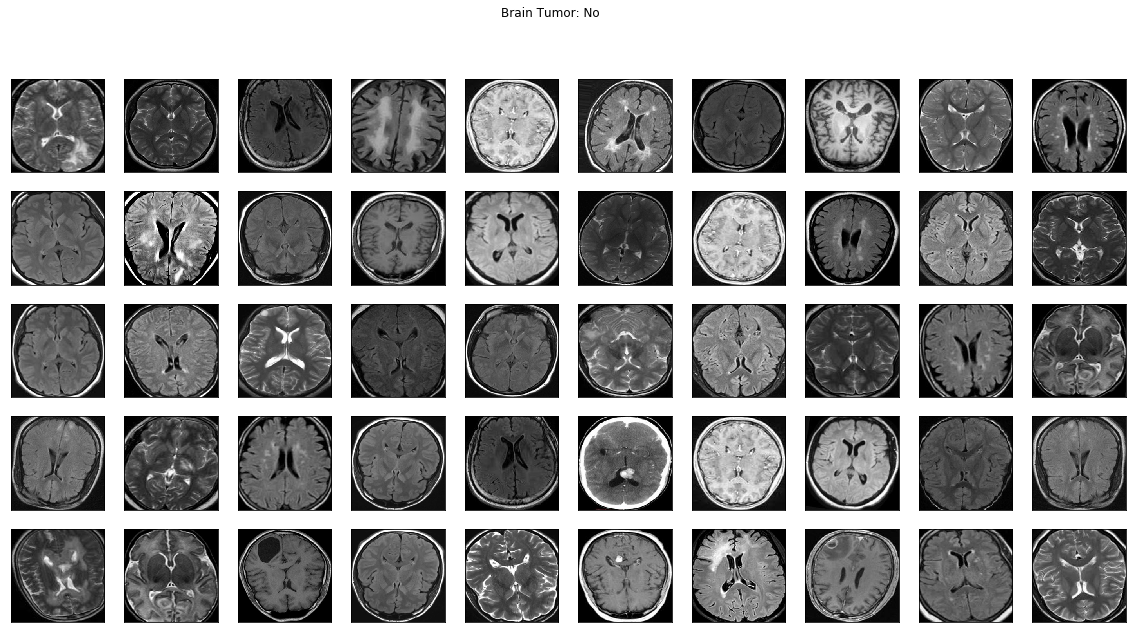

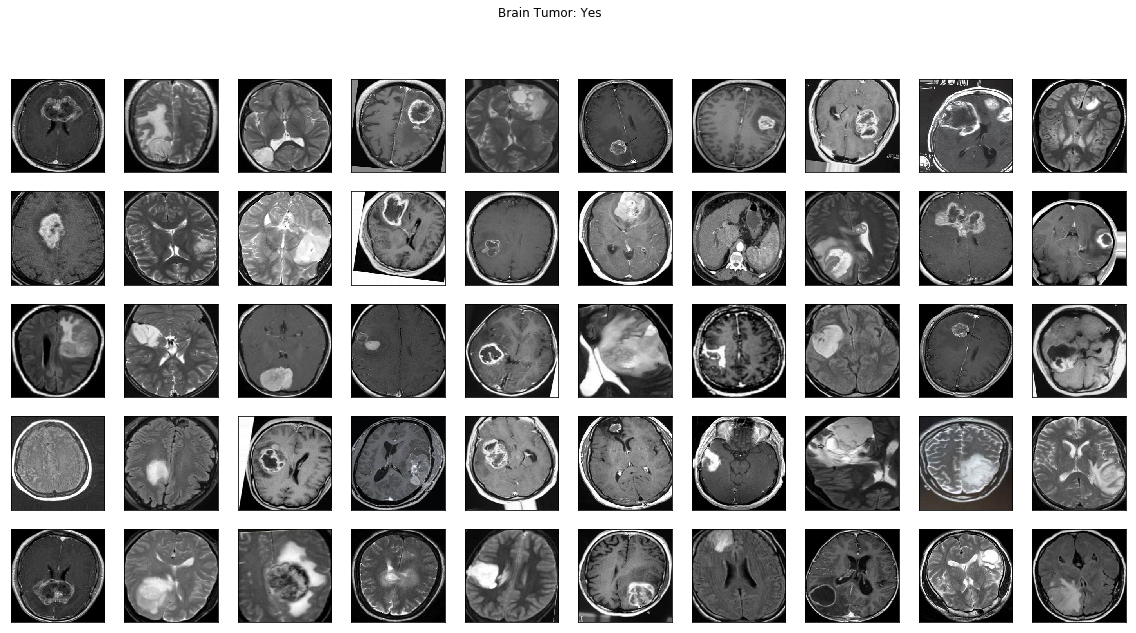

In [26]:
plot_sample_images(X, y)

# Split the data:
Split X and y into training, validation (development) and validation sets.

In [27]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:

70% of the data for training.
15% of the data for validation.
15% of the data for testing.

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

# Build the model
Lets build a convolutional neural network model:
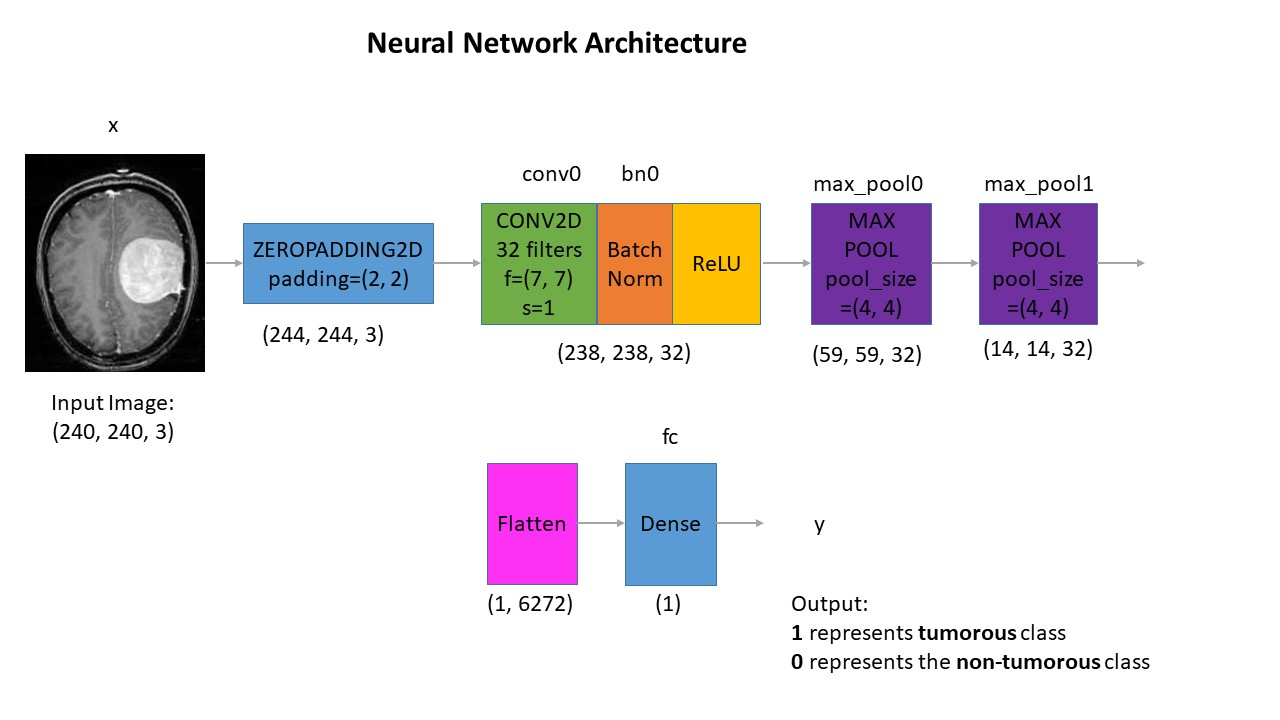



In [29]:
def build_model(input_shape):
  
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [30]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [31]:
model = build_model(IMG_SHAPE)

W1114 20:29:53.621644  5700 deprecation.py:506] From C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

# Compile the model:

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W1114 20:30:00.508236  5700 deprecation.py:323] From C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [37]:

def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Train the model

In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1444 samples, validate on 310 samples
Epoch 1/10
1444/1444 [==============================] - 330s 229ms/sample - loss: 0.1618 - acc: 0.9418 - val_loss: 0.5814 - val_acc: 0.7710
Epoch 2/10
1444/1444 [==============================] - 329s 228ms/sample - loss: 0.1494 - acc: 0.9522 - val_loss: 1.4884 - val_acc: 0.5710
Epoch 3/10
1444/1444 [==============================] - 309s 214ms/sample - loss: 0.2018 - acc: 0.9231 - val_loss: 0.4424 - val_acc: 0.8516
Epoch 4/10
1444/1444 [==============================] - 303s 210ms/sample - loss: 0.2111 - acc: 0.9169 - val_loss: 0.4338 - val_acc: 0.8581
Epoch 5/10
1444/1444 [==============================] - 305s 211ms/sample - loss: 0.1192 - acc: 0.9605 - val_loss: 0.7730 - val_acc: 0.7290
Epoch 6/10
1444/1444 [==============================] - 309s 214ms/sample - loss: 0.1126 - acc: 0.9605 - val_loss: 0.3932 - val_acc: 0.8613
Epoch 7/10
1444/1444 [==============================] - 300s 208ms/sample - loss: 0.1166 - acc: 0.9584 - val_loss

# Plot Loss & Accuracy

In [39]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [40]:
history = model.history.history

In [41]:
for key in history.keys():
    print(key)

loss
acc
val_loss
val_acc


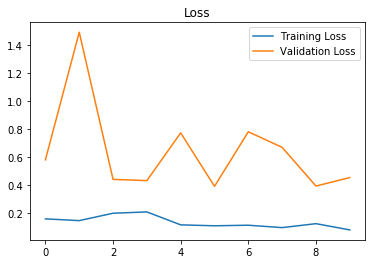

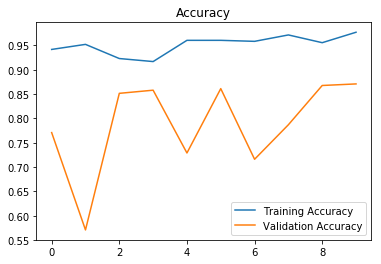

In [42]:
plot_metrics(history)

# Prediction

In [43]:
loss, acc = model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 10s 33ms/sample - loss: 0.4218 - acc: 0.8677


# Accuracy of the best model on the testing data:

In [44]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.42175605066360966
Test Accuracy = 0.8677419424057007
